## AFDist on fetched and decoded chunks

### Instance type is as for decode notebook

In [1]:
!pip install boto3 matplotlib aioboto3 aiobotocore numcodecs
import boto3
import aioboto3
from botocore.config import Config
import matplotlib.pyplot as plt
import time
from concurrent.futures import ThreadPoolExecutor

In [2]:
s3_client = boto3.client('s3', config=Config(max_pool_connections=512))

In [3]:
bucket="lifebit-user-data-1f2bfdf2-1d99-488c-9b87-246c62b66ea7"

In [4]:
#keys = [f"GEL-256534/call_genotype/{i}/{j}/0" for i in range(4000) for j in range(16)]
keys = [(v,s) for v in range(4000) for s in range(16)]

In [5]:
from numcodecs.blosc import Blosc
from numcodecs import blosc
blosc.init()
blosc.set_nthreads(1)
#Need to call this twice, not sure why!
blosc.set_nthreads(1)

1

## Numba afdist code - note that this can be run in parallel writing to the same numpy output arrays as long as the chunks are independent

In [6]:
import numba 
from numba import types
import numpy as np

@numba.jit(
    (
    types.int64,  # offset
    types.Array(types.int8, 3, 'C', readonly=True),  # G (blosc buffer)
    types.Array(types.int32, 1, 'C'),  # hom_ref
    types.Array(types.int32, 1, 'C'),  # hom_alt
    types.Array(types.int32, 1, 'C'),  # het
    types.Array(types.int32, 1, 'C')   # ref_count
), nopython=True, nogil=True
)
def count_genotypes_chunk_subset(
    offset, G, hom_ref, hom_alt, het, ref_count):
    #NB Assuming diploids and no missing data!
    index = offset
    for j in range(G.shape[0]):
            for k in range(G.shape[1]):
                    a = G[j, k, 0]
                    b = G[j, k, 1]
                    if a == b:
                        if a == 0:
                            hom_ref[index] += 1
                        else:
                            hom_alt[index] += 1
                    else:
                        het[index] += 1
                    ref_count[index] += (a == 0) + (b == 0)
            index += 1

In [7]:
## We add the AFDist func in the thread that did the decoding of the chunk.

In [8]:
import asyncio
import aioboto3
import multiprocessing as mp
from collections import defaultdict
import time
import os
from typing import List, Dict
import statistics
from dataclasses import dataclass
from concurrent.futures import ProcessPoolExecutor
import numpy as np

NUM_VAR=59880903

@dataclass
class BatchStats:
    process_id: int
    start_time: float
    total_bytes: int
    data_bytes: int
    files_completed: int
    duration: float = None
    
class S3BulkFetcher:
    def __init__(self, bucket: str, keys: List[str], num_processes: int = None, batch_size: int = 500, decode_threads=8):
        self.bucket = bucket
        self.keys = keys
        self.num_processes = num_processes or mp.cpu_count()
        self.batch_size = batch_size
        self.work_queue = mp.Queue()
        self.stats_queue = mp.Queue()
        self.decode_threads = decode_threads
        
    def prepare_batches(self):
        batches = [
            self.keys[i:i+self.batch_size] 
            for i in range(0, len(self.keys), self.batch_size)
        ]
        for batch in batches:
            self.work_queue.put(batch)
            
        for _ in range(self.num_processes):
            self.work_queue.put(None)
    
    async def process_batch(self, batch: List[str], session, decoder, thread_pool) -> BatchStats:
        stats = BatchStats(
            process_id=os.getpid(),
            start_time=time.time(),
            total_bytes=0,
            data_bytes=0,
            files_completed=0
        )

        hom_ref = np.zeros(NUM_VAR, dtype="int32")
        hom_alt = np.zeros(NUM_VAR, dtype="int32")
        het = np.zeros(NUM_VAR, dtype="int32")
        ref_count = np.zeros(NUM_VAR, dtype="int32")
        
        async with session.client('s3') as s3:
            async def fetch_single(key: str):
                v, s = key
                key = f"GEL-256534/call_genotype/{v}/{s}/0"
                response = await s3.get_object(Bucket=self.bucket, Key=key)
                raw_data = await response['Body'].read()
                return raw_data, v
            loop = asyncio.get_running_loop()

            def decode(raw_data,v_chunk):
                #return len(decoder.decode(raw_data))
                G = np.reshape(np.frombuffer(decoder.decode(raw_data), dtype="int8"), (10000,1000,2))
                count_genotypes_chunk_subset(v_chunk*10000,G, hom_ref, hom_alt, het, ref_count)
                return G.nbytes
            
            decompression_tasks = []
            for raw_data_v_chunk in asyncio.as_completed(
                [fetch_single(key) for key in batch]
            ):
                raw_data, v_chunk = await raw_data_v_chunk
                
                decompression_future = loop.run_in_executor(
                    thread_pool,
                    decode,
                    raw_data,
                    v_chunk
                )
                decompression_tasks.append((len(raw_data), decompression_future))
            for len_raw_data, decompression_future in decompression_tasks:
                len_data = await decompression_future
                stats.total_bytes += len_raw_data
                stats.data_bytes += len_data
                stats.files_completed += 1                
                    
        stats.duration = time.time() - stats.start_time
        return stats
    
    async def worker_loop(self):
        session = aioboto3.Session()
        decoder = Blosc.from_config({'cname': 'zstd', 'clevel': 7, 'shuffle': 2, 'blocksize': 0})
        thread_pool = ThreadPoolExecutor(max_workers=self.decode_threads)
        while True:
            batch = self.work_queue.get()
            if batch is None:  # sentinel value
                break
                
            stats = await self.process_batch(batch, session, decoder, thread_pool)
            self.stats_queue.put(stats)
        thread_pool.shutdown(wait=True)

    def worker_process(self):
        asyncio.run(self.worker_loop())

    def print_final_stats(self, all_stats: List[BatchStats], wall_time: float):
        total_bytes = sum(s.total_bytes for s in all_stats)
        total_data = sum(s.data_bytes for s in all_stats)
        total_files = sum(s.files_completed for s in all_stats)
        
        process_stats = defaultdict(lambda: {'bytes': 0, 'data':0, 'files': 0, 'batches': 0})
        for stat in all_stats:
            process_stats[stat.process_id]['bytes'] += stat.total_bytes
            process_stats[stat.process_id]['data'] += stat.data_bytes
            process_stats[stat.process_id]['files'] += stat.files_completed
            process_stats[stat.process_id]['batches'] += 1

        batch_times = [s.duration for s in all_stats]
        
        # print("\n=== S3 Bulk Download Statistics ===")
        # print(f"\nOverall Performance:")
        # print(f"Total transfer: {total_bytes / 1000 / 1000:.2f} MB in {total_files} files")
        # print(f"Total data: {total_data / 1000 / 1000:.2f} MB in {total_files} chnnks")
        # print(f"Duration: {wall_time:.2f} seconds")
        # print(f"Throughput: {(total_bytes / 1000 / 1000) / wall_time:.2f} MB/s, "
        #      f"{total_files / wall_time:.1f} files/s")
        # print(f"Data Throughput: {(total_data / 1000 / 1000) / wall_time:.2f} MB/s, "
        #      f"{total_files / wall_time:.1f} chunks/s")
        
        # print("\nBatch Statistics:")
        # print(f"Batch times - min: {min(batch_times):.2f}s, "
        #      f"max: {max(batch_times):.2f}s, "
        #      f"avg: {statistics.mean(batch_times):.2f}s")
        
        # print("\nPer-Process Performance:")
        # for pid, stats in process_stats.items():
        #    print(f"Process {pid}:")
        #    print(f"  Throughput: {(stats['bytes'] / 1000 / 1000) / wall_time:.2f} MB/s, "
        #          f"{stats['files'] / wall_time:.1f} files/s")
        #    print(f"  Data Throughput: {(stats['data'] / 1000 / 1000) / wall_time:.2f} MB/s, "
        #          f"{stats['files'] / wall_time:.1f} chunks/s")
        #    print(f"  Processed: {stats['files']} files in {stats['batches']} batches")

    def run(self):
        start_time = time.time()
        
        # Prepare work batches
        self.prepare_batches()
        
        # Start worker processes
        processes = []
        for _ in range(self.num_processes):
            p = mp.Process(target=self.worker_process)
            p.start()
            processes.append(p)
            
        # Collect all stats
        all_stats = []
        stats_to_collect = len([b for b in self.keys[::self.batch_size]])
        
        while len(all_stats) < stats_to_collect:
            stats = self.stats_queue.get()
            all_stats.append(stats)
            
            # Optional: Print progress
            #if len(all_stats) % 10 == 0:
            #    print(f"Progress: {len(all_stats)}/{stats_to_collect} batches complete")
        
        # Wait for all processes to complete
        for p in processes:
            p.join()
            
        wall_time = time.time() - start_time
        
        # Print final statistics
        self.print_final_stats(all_stats, wall_time)
        
        return all_stats



In [9]:
import math 

def run_scaling_benchmark(
    fetcher_class,
    bucket,
    keys,
    batch_size,
    min_processes,
    max_processes,
    max_compute_threads
):
    process_counts = []
    throughputs = []
    data_throughputs = []
    
    n_proc = min_processes
    
    while n_proc <= max_processes:
        n_decode_threads = min(max_compute_threads, math.ceil(96/n_proc))
        print(f"\nTesting with {n_proc} processes with {n_decode_threads} threads each...")
        fetcher = fetcher_class(
            bucket=bucket,
            keys=keys[:n_proc*batch_size*32],
            num_processes=n_proc,
            batch_size=batch_size,
            decode_threads=n_decode_threads
        )
        
        start_time = time.time()
        stats = fetcher.run()
        duration = time.time() - start_time
        
        total_bytes = sum(s.total_bytes for s in stats)
        throughput = (total_bytes / 1000 / 1000) / duration  # MB/s
        total_data = sum(s.data_bytes for s in stats)
        data_throughput = (total_data / 1000 / 1000) / duration  # MB/s
        
        process_counts.append(n_proc)
        throughputs.append(throughput)
        data_throughputs.append(data_throughput)
        
        print(f"Throughput with {n_proc} processes: {throughput:.2f} MB/s")
        print(f"Data Throughput with {n_proc} processes: {data_throughput:.2f} MB/s")
        
        n_proc *= 2
        
    return process_counts, throughputs, data_throughputs

def plot_scaling(process_counts, throughputs, data_throughputs, title= "S3 Throughput Scaling"):
    plt.figure(figsize=(10, 6))
    # plt.plot(process_counts, throughputs, 'bo-', linewidth=2, markersize=8)
    plt.plot(process_counts, data_throughputs, 'bo-', linewidth=2, markersize=8)
    
    plt.xscale('log', base=2)
    plt.grid(True, which="both", ls="-", alpha=0.2)
    
    plt.xlabel("Number of Processes")
    plt.ylabel("AFDist Throughput (MB/s)")
    plt.title(title)
    
    plt.legend()
    plt.tight_layout()


## Firstly with one compute thread per process


Testing with 1 processes with 1 threads each...
Throughput with 1 processes: 1.91 MB/s
Data Throughput with 1 processes: 645.00 MB/s

Testing with 2 processes with 1 threads each...
Throughput with 2 processes: 3.45 MB/s
Data Throughput with 2 processes: 1270.03 MB/s

Testing with 4 processes with 1 threads each...
Throughput with 4 processes: 6.28 MB/s
Data Throughput with 4 processes: 2499.37 MB/s

Testing with 8 processes with 1 threads each...
Throughput with 8 processes: 11.50 MB/s
Data Throughput with 8 processes: 4835.37 MB/s

Testing with 16 processes with 1 threads each...
Throughput with 16 processes: 24.96 MB/s
Data Throughput with 16 processes: 9794.53 MB/s

Testing with 32 processes with 1 threads each...
Throughput with 32 processes: 46.66 MB/s
Data Throughput with 32 processes: 18588.08 MB/s

Testing with 64 processes with 1 threads each...
Throughput with 64 processes: 68.14 MB/s
Data Throughput with 64 processes: 27146.21 MB/s

Testing with 128 processes with 1 thread

/tmp/ipykernel_16613/3035977232.py:61: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


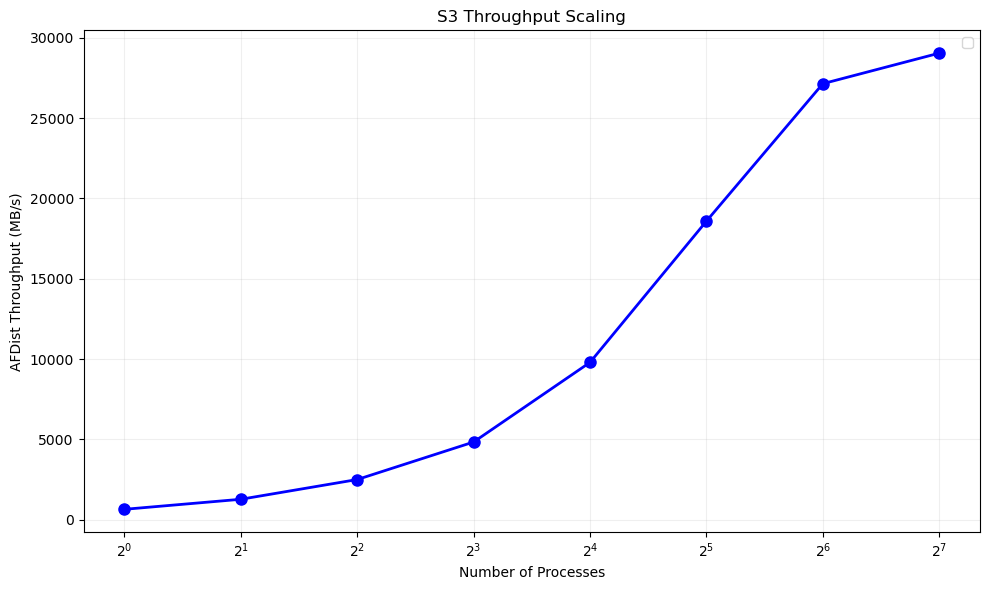

In [10]:
#c5.24xlarge
process_counts, throughputs, data_throughputs = run_scaling_benchmark(
        S3BulkFetcher,
        bucket=bucket,
        keys=keys,
        batch_size=100,
        min_processes=1,
        max_processes=128,
        max_compute_threads=1
    )
print(process_counts, throughputs, data_throughputs)
plot_scaling(process_counts, throughputs, data_throughputs)

## Now splitting the cores to the processes


Testing with 1 processes with 96 threads each...
Throughput with 1 processes: 10.76 MB/s
Data Throughput with 1 processes: 3632.95 MB/s

Testing with 2 processes with 48 threads each...
Throughput with 2 processes: 18.13 MB/s
Data Throughput with 2 processes: 6671.16 MB/s

Testing with 4 processes with 24 threads each...
Throughput with 4 processes: 31.17 MB/s
Data Throughput with 4 processes: 12403.64 MB/s

Testing with 8 processes with 12 threads each...
Throughput with 8 processes: 50.74 MB/s
Data Throughput with 8 processes: 21330.84 MB/s

Testing with 16 processes with 6 threads each...
Throughput with 16 processes: 70.17 MB/s
Data Throughput with 16 processes: 27533.03 MB/s

Testing with 32 processes with 3 threads each...
Throughput with 32 processes: 72.97 MB/s
Data Throughput with 32 processes: 29069.70 MB/s

Testing with 64 processes with 2 threads each...
Throughput with 64 processes: 73.26 MB/s
Data Throughput with 64 processes: 29186.17 MB/s

Testing with 128 processes wi

/tmp/ipykernel_16613/3035977232.py:61: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


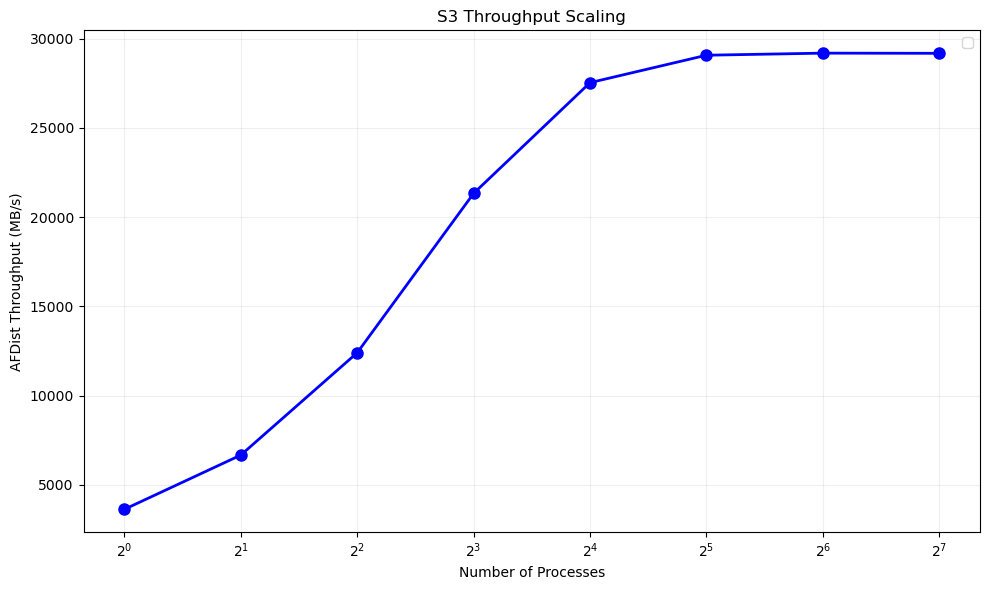

In [11]:
#c5.24xlarge
process_counts, throughputs, data_throughputs = run_scaling_benchmark(
        S3BulkFetcher,
        bucket=bucket,
        keys=keys,
        batch_size=100,
        min_processes=1,
        max_processes=128,
        max_compute_threads=1000
    )
print(process_counts, throughputs, data_throughputs)
plot_scaling(process_counts, throughputs, data_throughputs)